# Machine Learning - Project

In [2]:
%pip install imbalanced-learn
%pip install matplotlib
%pip install pandas
%pip install scikit-learn
%pip install seaborn

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


# Columns Definitions

Here is the meaning of every columns explain in `Xente_Variable_Definitions.csv`.

 * **TransactionId**: Unique transaction identifier on platform
 * **BatchId**: Unique number assigned to a batch of transactions for processing
 * **AccountId**: Unique number identifying the customer on platform
 * **SubscriptionId**: Unique number identifying the customer subscription
 * **CustomerId**: Unique identifier attached to Account
 * **CurrencyCode**: Country currency
 * **CountryCode**: Numerical geographical code of country
 * **ProviderId**: Source provider of Item bought.
 * **ProductId**: Item name being bought.
 * **ProductCategory**: ProductIds are organized into these broader product categories.
 * **ChannelId**: Identifies if customer used web,Android, IOS, pay later or checkout.
 * **Amount**: Value of the transaction. Positive for debits from customer account and negative for credit into customer account
 * **Value**: Absolute value of the amount
 * **TransactionStartTime**: Transaction start time
 * **PricingStrategy**: Category of Xente's pricing structure for merchants
 * **FraudResult**: Fraud status of transaction 1 -yes or 0-No


# Load training data

The first thing we do is to load the training data from `training.csv`.

In [3]:
training_data_path = './data/training.csv'

# Read data from file
training_data = pd.read_csv(training_data_path)

# Set the 'TransactionId' as index
training_data.set_index('TransactionId', inplace=True)

training_data.head(5)

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId,,,,,,,,,,,,,,,
TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


# Data analysis

Now that we have our data loaded, we will analyse the differents data in order the get the best possible model.

# Mutual Information

First thing first, we will look at the relationship between every columns and the target value.

In [4]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [5]:
# Define the datasets
X = training_data.copy()
y = X.pop('FraudResult')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Get the discrete features by checking that it is a int
discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores


Amount                  0.013276
AccountId               0.010132
Value                   0.008339
SubscriptionId          0.008076
CustomerId              0.005404
ProductCategory         0.002986
BatchId                 0.002902
TransactionStartTime    0.002732
CurrencyCode            0.002556
ProductId               0.001840
PricingStrategy         0.001836
CountryCode             0.001558
ChannelId               0.001447
ProviderId              0.000527
Name: MI Scores, dtype: float64

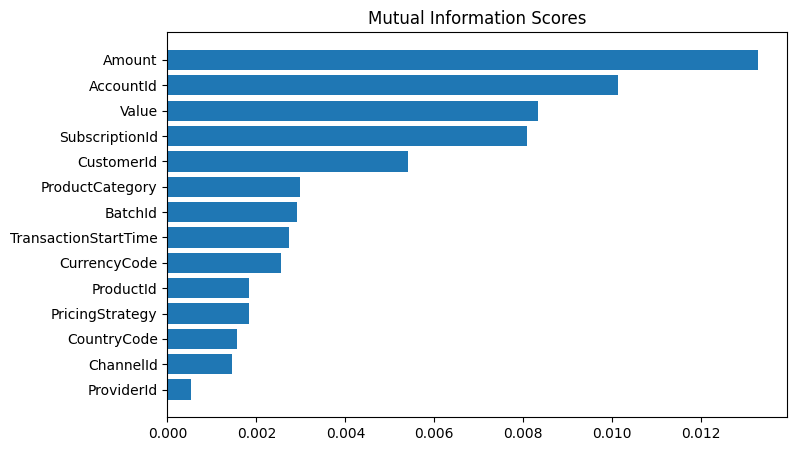

In [6]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

As we can see in the plot, the `BatchId` is the most dominant columns. But we cannot take this one into account as it is a biased value due to the fact the the `BatchId`is only an identification for the transaction.

Same for `CustomerId`, `AccountId` and `SubscriptionId`, because they refers to customers. We do not want to predict a fraud based on the customers habits.

Based on what have been said before, here is the new Mutual Information removing the following columns: `BatchId`, `CustomerId`, `AccountId` and `SubscriptionId`.

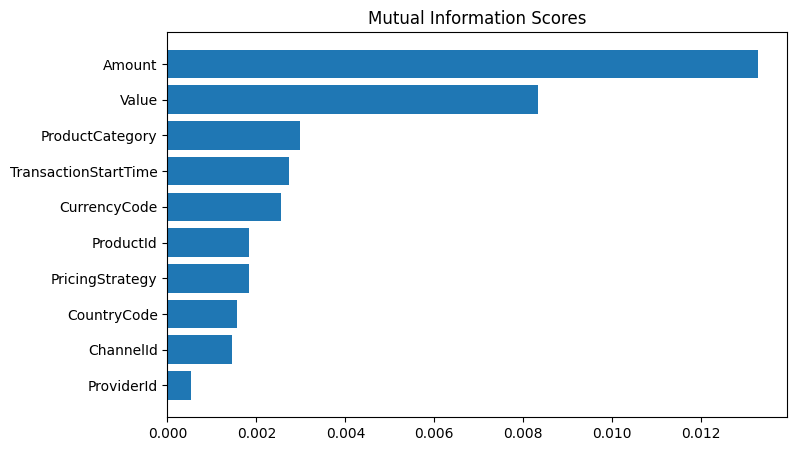

In [7]:
# Define columns to remove
ColsToRemove = ['BatchId', 'CustomerId', 'AccountId', 'SubscriptionId']

# Remove useless columns
mi_scores_copy = mi_scores.drop(ColsToRemove)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores_copy)

## Transaction country

First, we will attack with the columns `CurrencyCode` and `CountryCode`. Actually, they point to the same thing: from which country the transaction has been done. Thus, we can say that having both columns is redundant to estimate our model prediction.

We will first look at the occurence of every country and then check its relationship with the target value.

In [8]:
# Load CurrencyCode and CountryCode
X_CurrencyCode = training_data['CurrencyCode']
X_CountryCode = training_data['CountryCode']

# Count occurence of each rows
CurrencyCode_Occurences = X_CurrencyCode.value_counts()
CountryCode_Occurences = X_CountryCode.value_counts()

# Show information
print(CurrencyCode_Occurences)
print('\n---\n')
print(CountryCode_Occurences)

CurrencyCode
UGX    95662
Name: count, dtype: int64

---

CountryCode
256    95662
Name: count, dtype: int64


As we can see, `CurrencyCode` and `CountryCode` has only one distinct value in all the dataset. Give that, we can say that this columns will not give any additional information to our model.

Based on the Mutual Information calculated above, we can see than `CurrencyCode` and `CountryCode` are independent variables.

## Transaction Start Time

As information, we have `TransactionStartTime` and it is the transaction start time. It is written using the [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) date format. In this form, we cannot exploit the data in our model.

From the date, we can take some interesting information such as:
 * Day of the week
 * Month
 * Period of the year

By retrieving this information, we can try to visualise if the fraud is something periodically, that happens on certain week day, ...

Given that, our first step will be to preprocessing our data and create 2 new columns: `TransactionWeekDay` and `TransactionMonth.`

 * **TransactionWeekDay**: 0 - 6
 * **TransactionMonth**: 0 - 11

In [17]:
def apply_transaction_start_date(destination):
    # Convert every string in datetime object
    pdDatetime = pd.to_datetime(destination['TransactionStartTime'])
    pdDatetimeIndex = pd.DatetimeIndex(pdDatetime)

    # Retrieve month and week day
    destination['TransactionMonth'] = pdDatetimeIndex.month
    destination['TransactionHour'] = pdDatetimeIndex.hour
    destination['TransactionWeekDay'] = pdDatetimeIndex.weekday

    # Drop TransactionStartTime
    destination.drop(columns=['TransactionStartTime'], inplace=True)

    return destination

In [18]:
# Create DataFrame
TransactionStartTimeDetails = training_data.loc[:, ['TransactionStartTime']].copy()

# Convert string to usable start date
TransactionStartTimeDetails = apply_transaction_start_date(TransactionStartTimeDetails)

TransactionStartTimeDetails.head()


,TransactionMonth,TransactionHour,TransactionWeekDay
TransactionId,,,
TransactionId_76871,11,2,3
TransactionId_73770,11,2,3
TransactionId_26203,11,2,3
TransactionId_380,11,3,3
TransactionId_28195,11,3,3


# Fraud frequency per week day

We will know plot the fraud frequency regarding the month.

In [19]:
# Create DataFram with the month and fraud
FraudMonth = pd.DataFrame({
    'TransactionWeekDay': TransactionStartTimeDetails['TransactionWeekDay'],
    'FraudResult': training_data['FraudResult'],
})

# Group the dataframe by month
FraudPerWeekDay = FraudMonth.groupby('TransactionWeekDay').sum()
FraudPerWeekDay.reset_index(inplace=True)

FraudPerWeekDay.head(10)

,TransactionWeekDay,FraudResult
0,0,29
1,1,31
2,2,29
3,3,34
4,4,30
5,5,25
6,6,15


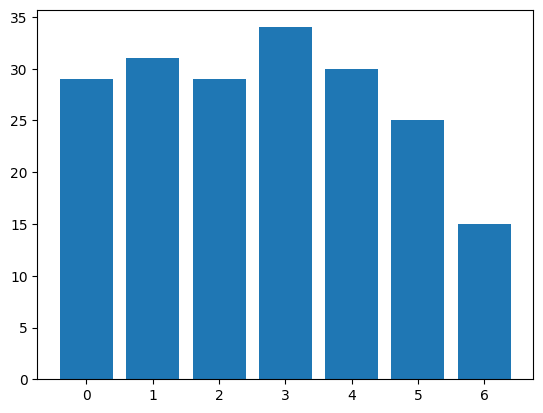

In [20]:
# Creating histogram
plt.bar(FraudPerWeekDay['TransactionWeekDay'], FraudPerWeekDay['FraudResult'])
 
# Show plot
plt.show()

We see that there is no pattern that appears between the week days. A fraud can happens any day of the week. Given that, I will not use `TransactionWeekDay` in my model.

# Fraud frequency per month

We will know plot the fraud frequency regarding the month.

In [21]:
# Create DataFram with the month and fraud
FraudMonth = pd.DataFrame({
    'TransactionMonth': TransactionStartTimeDetails['TransactionMonth'],
    'FraudResult': training_data['FraudResult'],
})

# Group the dataframe by month
FraudPerMonth = FraudMonth.groupby('TransactionMonth').sum()
FraudPerMonth.reset_index(inplace=True)

FraudPerMonth.head(10)

,TransactionMonth,FraudResult
0,1,64
1,2,53
2,11,14
3,12,62


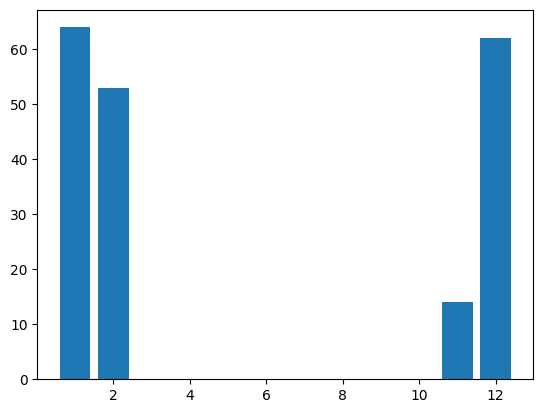

In [22]:
# Creating bar graph
plt.bar(FraudPerMonth['TransactionMonth'], FraudPerMonth['FraudResult'])
 
# Show plot
plt.show()

In [23]:
from sklearn.cluster import KMeans

As we can see, there is a periodical pattern. The fraud generally happens during the month of november to february.

We can then use this data in our model.

# Fraud frequency per hour

We will analyse the frequency of the fraud regarding the hour of the day.

In [24]:
# Create DataFram with the month and fraud
FraudHour = pd.DataFrame({
    'TransactionHour': TransactionStartTimeDetails['TransactionHour'],
    'FraudResult': training_data['FraudResult'],
})

# Group the dataframe by month
FraudPerHour = FraudHour.groupby('TransactionHour').sum()
FraudPerHour.reset_index(inplace=True)

FraudPerHour.head(10)

,TransactionHour,FraudResult
0,0,1
1,1,0
2,2,0
3,3,7
4,4,0
5,5,6
6,6,7
7,7,9
8,8,8
9,9,10


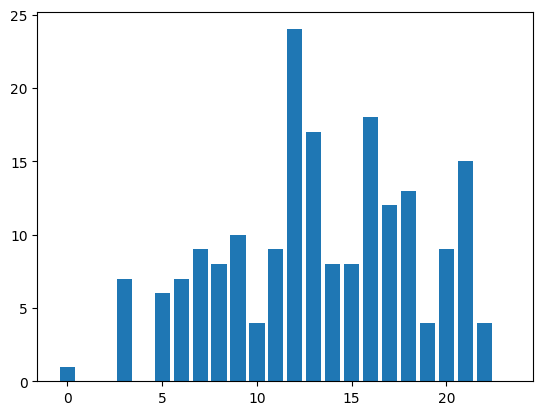

In [25]:
# Creating bar graph
plt.bar(FraudPerHour['TransactionHour'], FraudPerHour['FraudResult'])
 
# Show plot
plt.show()

In [26]:
from sklearn.cluster import KMeans

def kmeansFraudHour(destination, clusters=3, computeFraudPerHour=True):
    # Create KMeans instance
    kmeans = KMeans(n_clusters=clusters)

    # Check if we have to compute how many fraud happens per hour
    if computeFraudPerHour:
        FraudHour = pd.DataFrame({
            'TransactionHour': destination['TransactionHour'],
            'FraudResult': destination['FraudResult'],
        })

        # Group the dataframe by month
        FraudPerHour = FraudHour.groupby('TransactionHour').sum()
        FraudPerHour.reset_index(inplace=True)

        # Get the cluster result
        destination['TransactionHourCluster'] = kmeans.fit_predict(FraudPerHour.loc[:, ['FraudResult']])
        destination['TransactionHourCluster'] = destination['TransactionHourCluster'].astype('category')

    else:
        # Get the cluster result
        destination['TransactionHourCluster'] = kmeans.fit_predict(destination.loc[:, ['FraudResult']])
        destination['TransactionHourCluster'] = destination['TransactionHourCluster'].astype('category')

    return destination

In [27]:
FraudPerHour = kmeansFraudHour(FraudPerHour, computeFraudPerHour=False)
FraudPerHour.groupby('TransactionHourCluster').head()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,TransactionHour,FraudResult,TransactionHourCluster
0,0,1,2
1,1,0,2
2,2,0,2
3,3,7,0
4,4,0,2
5,5,6,0
6,6,7,0
7,7,9,0
8,8,8,0
10,10,4,2


<Axes: xlabel='TransactionHour', ylabel='FraudResult'>

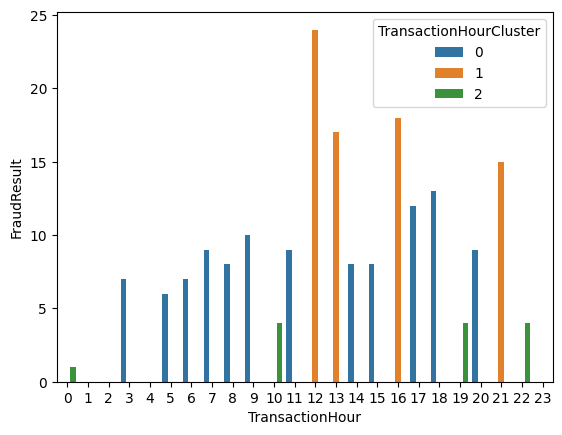

In [28]:
# Creating bar graph
sns.barplot(data=FraudPerHour, x="TransactionHour", y="FraudResult", hue="TransactionHourCluster")

**TODO**

DOC

## Result

As we can see in this plot, it is not a periodical pattern and so the month and week day does not give us any additional information.

But for the sake of the analysis, we will keep `TransactionMonth` and `TransactionWeekDay`, because `TransactionStartTime` will be just converted in a categorical variable that will bias our model.

In [29]:
def get_transaction_start_date_data(destination):
    # Get useful data from TransactionStartDate
    destination = apply_transaction_start_date(destination)
    
    # Remove TransactionWeekDay
    destination.drop(colname=TransactionWeekDay, inplace=True)

    # Clusterise hour
    kmeansFraudHour(destination)

## Way to pay

For the next analysis, we will look at `Amount`. In the variable description, it says that the positive values refers to debit and negative to credit.

Given that information, we can analyse if a debit or credit payment affect the fraud violation.

The first step will be to extract this information, we will then create a column name `PaymentWay`. This column will have `0` if it is a debit and `1` if credit.

 * **PaymentWay**: 0 if debit, 1 if credit

In [30]:
def apply_payment_way(destination):
    # Get the payment information
    destination['PaymentWay'] = np.where(destination['Amount'] > 0, 'debit', 'credit')

    kmeans = KMeans(n_clusters=2)

    destination['PaymentWay'], _ = pd.factorize(destination['PaymentWay'])

    # Get the cluster result
    destination['ValueCluster'] = kmeans.fit_predict(destination.loc[:, ['Value', 'PaymentWay']])
    destination['ValueCluster'] = destination['ValueCluster'].astype('category')

    # Remove the Amount columns
    destination.drop(columns=['Amount'], inplace=True)

    return destination

In [31]:
# Create an empty DataFrame
PaymentInformation = training_data.loc[:, ['Amount', 'Value']].copy()

# Apply the payment way function
PaymentInformation = apply_payment_way(PaymentInformation)

PaymentInformation.head()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Value,PaymentWay,ValueCluster
TransactionId,,,
TransactionId_76871,1000,0,0
TransactionId_73770,20,1,0
TransactionId_26203,500,0,0
TransactionId_380,21800,0,0
TransactionId_28195,644,1,0


### Mutual Information for Payment Way

We can now make the Mutual Information between `PaymentWay`and the target value.

In [32]:
# Define the variable to check the relationship
X = PaymentInformation.copy()
y = training_data['FraudResult']

# Categorise PaymentWay
X['PaymentWay'], _ = X['PaymentWay'].factorize()

# Get the discrete features just to be sure
discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

Value           0.015209
ValueCluster    0.004816
PaymentWay      0.002807
Name: MI Scores, dtype: float64

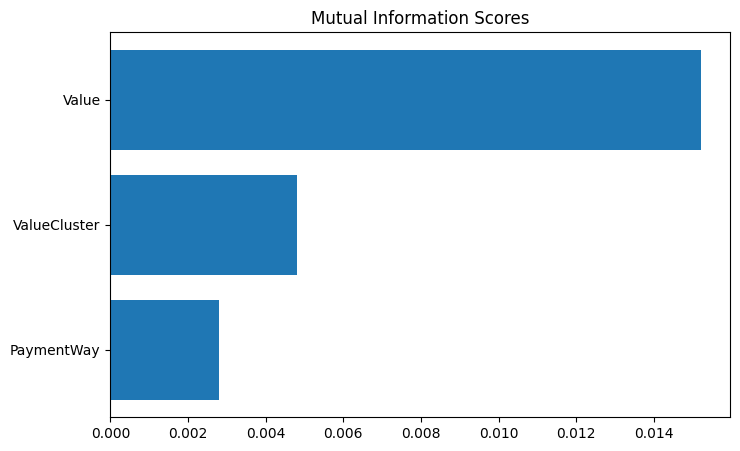

In [33]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

As we can see, the payment way does not affect the fraud violation.

### Fraud frequency per Payment Way

We will analyse the fraud frequency regarding the payment method used: Debit or Credit.

In [34]:
# Create DataFram with the month and fraud
FraudPaymentWay = pd.DataFrame({
    'PaymentWay': PaymentInformation['PaymentWay'],
    'FraudResult': training_data['FraudResult'],
})


# Group the dataframe by month
FraudPerPaymentWay = FraudPaymentWay.groupby('PaymentWay').sum()
FraudPerPaymentWay.reset_index(inplace=True)

FraudPerPaymentWay.head(10)

,PaymentWay,FraudResult
0,0,188
1,1,5


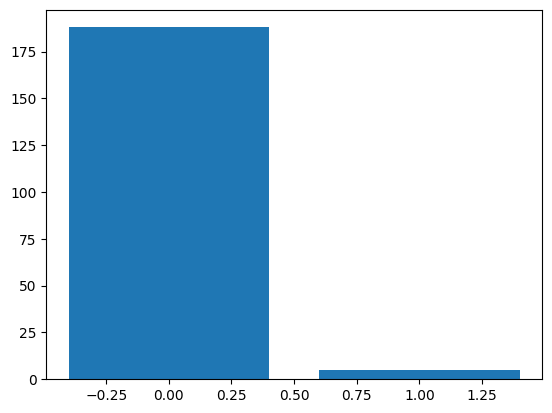

In [35]:
# Creating bar graph
plt.bar(FraudPerPaymentWay['PaymentWay'], FraudPerPaymentWay['FraudResult'])
 
# Show plot
plt.show()

## Pricing strategy

We are going to analyse the pricing strategy and check its influence on the fraud detection.

In [36]:
# Retrieve the pricing strategy
PricingStrategy = training_data.loc[:, ['PricingStrategy', 'FraudResult']]

# Check the number of fraud per princing strategy
FraudPerPricingStrategy = PricingStrategy.groupby('PricingStrategy').sum()
FraudPerPricingStrategy.reset_index(inplace=True)

FraudPerPricingStrategy.head()

,PricingStrategy,FraudResult
0,0,36
1,1,7
2,2,139
3,4,11


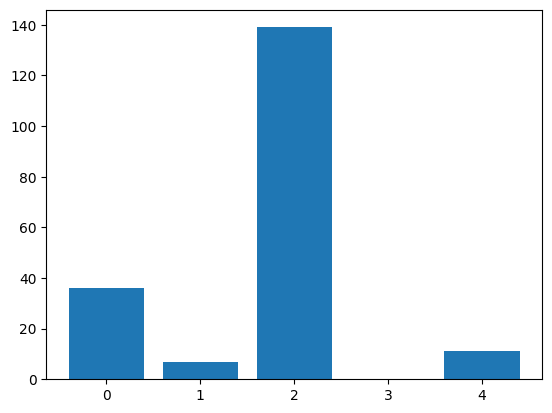

In [37]:
# Creating bar graph
plt.bar(FraudPerPricingStrategy['PricingStrategy'], FraudPerPricingStrategy['FraudResult'])
 
# Show plot
plt.show()

# Value

**TODO** Clustering on value

In [38]:
from sklearn.cluster import KMeans

def kmeansValue(destination, clusters=3, dropValue=True):
    destination['Value'] = (destination['Value'] - destination['Value'].min()) / (destination['Value'].max() - destination['Value'].min()) 

    # Create KMeans instance
    kmeans = KMeans(n_clusters=clusters)

    # Get the cluster result
    destination['ValueCluster'] = kmeans.fit_predict(destination.loc[:, ['Value']])
    destination['ValueCluster'] = destination['ValueCluster'].astype('category')

    if dropValue:
        destination.drop(columns=['Value'], inplace=True)

    return destination

In [39]:
# Get Value
Value = training_data.loc[:, ['Value']].copy()

# Apply KMeans onn Value
Value = kmeansValue(Value, clusters=5, dropValue=False)

Value.head()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Value,ValueCluster
TransactionId,,
TransactionId_76871,0.000101,0
TransactionId_73770,0.000002,0
TransactionId_26203,0.000050,0
TransactionId_380,0.002206,0
TransactionId_28195,0.000065,0


<Axes: xlabel='ValueCluster', ylabel='Value'>

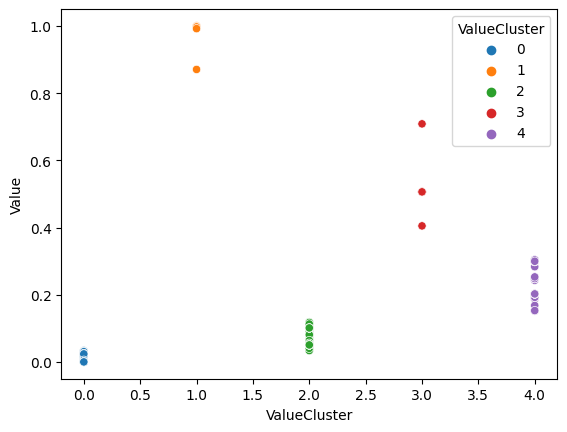

In [40]:
sns.scatterplot(data=Value, x='ValueCluster', y='Value', hue='ValueCluster')

In [41]:
ValuePaymentWay = training_data.loc[:, ['Amount', 'Value']].copy()

ValuePaymentWay = apply_payment_way(ValuePaymentWay)

kmeans = KMeans(n_clusters=2)

ValuePaymentWay['PaymentWay'], _ = pd.factorize(ValuePaymentWay['PaymentWay'])

# Get the cluster result
ValuePaymentWay['ValueCluster'] = kmeans.fit_predict(ValuePaymentWay.loc[:, ['Value', 'PaymentWay']])
ValuePaymentWay['ValueCluster'] = ValuePaymentWay['ValueCluster'].astype('category')


ValuePaymentWay['ValueCluster'].value_counts()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueCluster
0    95626
1       36
Name: count, dtype: int64

# Value per Customer

Value per customerId.

In [42]:
def get_value_per_customer(destination):
    # CustomerIdValue = destination.loc[:, ['CustomerId', 'Value']]
    # destination['Value'] = (destination['Value']-destination['Value'].min())/(destination['Value'].max()-destination['Value'].min())
    destination['ValerPerCustomer'] = destination.groupby(['TransactionId', 'CustomerId'])[['Value']].sum().reset_index().set_index('TransactionId')['Value']

    # for _, row in CustomerIdValue.iterrows():
    #     destination.loc[destination['CustomerId'] == row['CustomerId'], 'ValuePerCustomer'] = row['mean']

    # print(np.where(CustomerIdValue['CustomerId'] == destination['CustomerId']))

    return destination

In [43]:
training_data_copy = get_value_per_customer(training_data.copy())

training_data_copy.head(10)

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,ValerPerCustomer
TransactionId,,,,,,,,,,,,,,,,
TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0,1000
TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0,20
TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0,500
TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0,21800
TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0,644
TransactionId_23223,BatchId_25954,AccountId_1078,SubscriptionId_4238,CustomerId_1432,UGX,256,ProviderId_6,ProductId_3,airtime,ChannelId_3,2000.0,2000,2018-11-15T03:35:10Z,2,0,2000
TransactionId_118063,BatchId_118460,AccountId_2442,SubscriptionId_1980,CustomerId_2858,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,10000.0,10000,2018-11-15T03:44:31Z,4,0,10000
TransactionId_100640,BatchId_38561,AccountId_4841,SubscriptionId_3829,CustomerId_2858,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-500.0,500,2018-11-15T03:45:13Z,2,0,500
TransactionId_51905,BatchId_93774,AccountId_272,SubscriptionId_4731,CustomerId_598,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,500.0,500,2018-11-15T04:14:59Z,2,0,500


## Channel ID

In [44]:
# Retrieve the pricing strategy
ChannelId = training_data.loc[:, ['ChannelId', 'FraudResult']]

# Check the number of fraud per princing strategy
FraudPerChannelId = ChannelId.groupby('ChannelId').sum()
FraudPerChannelId.reset_index(inplace=True)

FraudPerChannelId.head()

,ChannelId,FraudResult
0,ChannelId_1,4
1,ChannelId_2,5
2,ChannelId_3,184
3,ChannelId_5,0


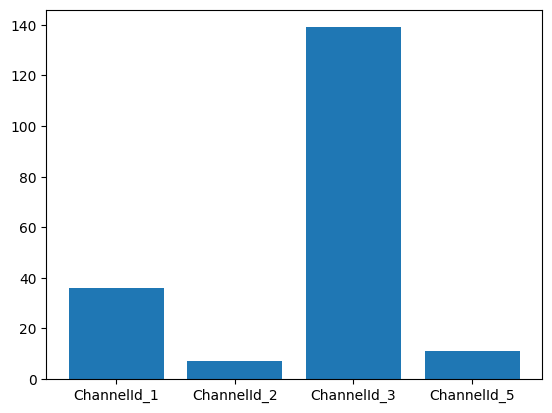

In [45]:
# Creating bar graph
plt.bar(FraudPerChannelId['ChannelId'], FraudPerPricingStrategy['FraudResult'])
 
# Show plot
plt.show()

## Conclusion

At the end of our journey, blah blah blah...

## Categorise the data

Now we are going the categorise our discrete value. We will apply a One-Hot Encoder on `ProductCategory` and `ChannelId`.

As a reminder, a One-Hot Encoder will create new binary columns, indicating the presence of each possible values from the original data.

![One-Hot Encoding](./pictures/one-hot-encoding.png)

One-Hot Encoding works well when the categorical variable takes on a small number of values (15 regarding [Kaggle](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding)).

We will then check the number of unique categories in every one of our columns, and apply One-Hot Encoding if the distinct values is less than `15`.


In [46]:
# Define the columns to categorise
CategoriseCols = ['ProductCategory']

# Extract our categorical variable
CategoricalVariable = training_data.loc[:, CategoriseCols]

# Get number of unique values in each column
CategoricalVariable.nunique()

ProductCategory    9
dtype: int64

As we can see, `ProductCategory` has 9 distincts values and `ChannelId`has 4. We can then apply One-Hot Encoding on each column.

# Set our data for the model

Here we are going to set the data that we will use to create our model.

In [69]:
# COLS_TO_USE = ['ProductCategory', 'ChannelId', 'Amount', 'TransactionStartTime', 'PricingStrategy']
COLS_TO_USE = ['Amount', 'TransactionStartTime', 'ProductCategory', 'ChannelId', 'Value', 'PricingStrategy', 'CustomerId']

def prepare_dataset(data_source):
    dataset = data_source[COLS_TO_USE].copy()

    # Apply data transformation
    dataset = get_value_per_customer(dataset)
    dataset = apply_payment_way(dataset)
    dataset = apply_transaction_start_date(dataset)

    dataset.drop(columns=['CustomerId', 'ValueCluster', 'TransactionWeekDay'], inplace=True)
    # dataset = kmeansValue(dataset, clusters=5)

    return dataset

In [70]:
from sklearn.model_selection import train_test_split

# Category where apply a One-Hot encoding
CategoriseCols = ['ProductCategory', 'ChannelId', 'PaymentWay', 'TransactionMonth', 'PricingStrategy']

# Check my dataset
# training_data.reset_index(inplace=True)
X = prepare_dataset(training_data)
y = training_data['FraudResult']

# X.drop(columns=['PaymentWay'], inplace=True)

# Apply One-Hot encoding
X = pd.get_dummies(data=X, columns=CategoriseCols)

# Stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0, stratify=y)


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [71]:
X_train.head()

,Value,ValerPerCustomer,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,...,PaymentWay_0,PaymentWay_1,TransactionMonth_1,TransactionMonth_2,TransactionMonth_11,TransactionMonth_12,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4
TransactionId,,,,,,,,,,,,,,,,,,,,,
TransactionId_10839,50,50,False,False,True,False,False,False,False,False,...,False,True,True,False,False,False,False,False,True,False
TransactionId_115893,20000,20000,False,False,True,False,False,False,False,False,...,True,False,False,False,False,True,False,False,True,False
TransactionId_28380,392,392,False,False,True,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,False
TransactionId_114004,500,500,False,True,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
TransactionId_3471,50,50,False,False,True,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,False


In [63]:
y_train.head()

TransactionId
TransactionId_10839     0
TransactionId_115893    0
TransactionId_28380     0
TransactionId_114004    0
TransactionId_3471      0
Name: FraudResult, dtype: int64

**TODO**

A this time we have
 * Column 1
 * COlumn 2
 * ...

# Unbalanced dataset

Before explaining what is a unbalanced datasets, I will show you the proportion between the non-fraud and fraud rows of the dataset.

In [ ]:
y = training_data['FraudResult']

# Compute the percentage value of fraud
fraud_percentage = y.sum() / len(y)

print(f'{fraud_percentage * 100.0}% of fraud.')

0.20175200183981098% of fraud.


In [ ]:
# Explain over sampling

# Create the model

**TODO**

For that we use a pipeline to automatically ...

## Preprocessing step

**TODO**

One Hot encoder

# Model

**TODO**

Define the model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Decision tree as first model
model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state = 0)

## Pipeline

**TODO**

Define the pipeline

In [ ]:
from sklearn.model_selection import GridSearchCV


model = RandomForestClassifier(n_estimators=5, max_depth=20, random_state=0)
parameters = {
    "n_estimators": [50, 100, 150],
    "max_depth": [20, 30, 40],
}

grid_search = GridSearchCV(model, param_grid = parameters , scoring = 'f1', cv = 3, n_jobs = 2,)
grid_scores = grid_search.fit(X_train , y_train)

KeyboardInterrupt: 

In [ ]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [55]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier


pipeline = Pipeline([
    # ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=0, sampling_strategy=0.3)),
    # ('scale', StandardScaler(with_mean=False)),
    ('model', RandomForestClassifier(n_estimators=150, max_depth=20, random_state = 0)),
])


In [ ]:
model = GradientBoostingClassifier(n_estimators=5, max_depth=20, learning_rate=0.1, random_state=1)
parameters = {
    "n_estimators": [50, 100, 150],
    "max_depth": [20, 30, 40],
    "learning_rate": [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(model, param_grid = parameters , scoring = 'f1', cv = 3, n_jobs = 2,)
grid_scores = grid_search.fit(X_train , y_train)

In [ ]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.best_params_)

GradientBoostingClassifier(learning_rate=0.01, max_depth=20, n_estimators=50,
                           random_state=1)
0.8764814440627736
{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 50}


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    # ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=0, sampling_strategy=0.4)),
    # ('scale', StandardScaler(with_mean=False)),
    ('model', GradientBoostingClassifier(n_estimators=50, max_depth=20, learning_rate=0.01, random_state=0)),
])


In [72]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=0, sampling_strategy=0.3)),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=150,
                                        random_state=0))])

In [73]:
preds = pipeline.predict(X_test)

print(f1_score(y_test, preds))

0.6947368421052632


# Predictions

**TODO**

We will make the prediction with our model

In [74]:
# Path to the test data
test_data_path = './data/test.csv'

# Load test data
test_data = pd.read_csv(test_data_path)

# Set TransactionId as index
test_data.set_index('TransactionId', inplace=True)

# Get the target
X_valid = prepare_dataset(test_data.copy())

# Apply One-Hot encoding
X_valid = pd.get_dummies(data=X_valid, columns=CategoriseCols)

# Remove the columns that are not in the training dataset
X_valid.drop(columns=[col for col in X_valid.columns if col not in X_train.columns], inplace=True)

# Add the columns that are missing from the training set
for col in X_train.columns:
    if col not in X_valid.columns:
      X_valid.insert(X_valid.shape[1], col, pd.Series([0] * X_valid.shape[0]))
      X_valid[col].fillna(0, inplace=True)

X_valid = X_valid[X_train.columns]


X_valid.isna().any()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Value                                 False
ValerPerCustomer                      False
ProductCategory_airtime               False
ProductCategory_data_bundles          False
ProductCategory_financial_services    False
ProductCategory_movies                False
ProductCategory_other                 False
ProductCategory_ticket                False
ProductCategory_transport             False
ProductCategory_tv                    False
ProductCategory_utility_bill          False
ChannelId_ChannelId_1                 False
ChannelId_ChannelId_2                 False
ChannelId_ChannelId_3                 False
ChannelId_ChannelId_5                 False
PaymentWay_0                          False
PaymentWay_1                          False
TransactionMonth_1                    False
TransactionMonth_2                    False
TransactionMonth_11                   False
TransactionMonth_12                   False
PricingStrategy_0                     False
PricingStrategy_1               

In [75]:
from sklearn.metrics import mean_absolute_error

pred = pd.Series(
    pipeline.predict(X_valid)
)

pred.head()


0    0
1    0
2    0
3    0
4    0
dtype: int64

In [76]:
sample_submission_path = './data/sample_submission.csv'

sample_submission =  pd.read_csv(sample_submission_path)

sample_submission['FraudResult'] = pred

sample_submission.to_csv('./data/my_submission.csv', index=False)